Naïve Bayes is a fast and efficient probabilistic machine learning model that classifies data based on Bayes’ Theorem. It assumes that features (like words in an email) are independent of each other and calculates the likelihood of a data point belonging to each class. In phishing detection, it analyzes the words in an email to predict whether it's phishing or legitimate based on learned word frequencies from the training data

In [45]:
#importing necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score

In [22]:
#downloading necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shriy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shriy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [23]:
#loading the dataset 
df=pd.read_csv("phishing_email.csv")

In [24]:
#viewing the data
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [25]:
df.describe()

,label
count,82486.000000
mean,0.519979
std,0.499604
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [27]:
df.shape

(82486, 2)

In [31]:
print(df['label'].value_counts())

label
1    42891
0    39595
Name: count, dtype: int64


C:\Users\shriy\AppData\Local\Temp\ipykernel_16812\4259547110.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


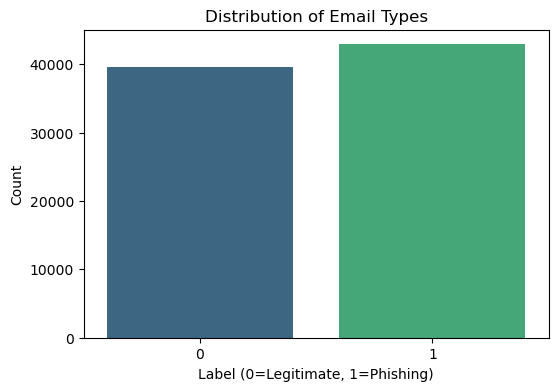

In [36]:
#bar chart for email type distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.xlabel("Label (0=Legitimate, 1=Phishing)")
plt.ylabel("Count")
plt.title("Distribution of Email Types")
plt.show()

This model has higher number of phishing emails compared to safe ones 
to prevent this imbalance from affecting the model performance

In [32]:
#cleaning the text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    return ''
df['cleaned_text'] = df['text_combined'].apply(clean_text)

In [38]:
#cleaning missing data
df = df.dropna(subset=['text_combined'])

In [33]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

In [34]:
#vectorizing the data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [39]:
#training the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

Accuracy: 0.9591465632197842

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      7919
           1       0.98      0.94      0.96      8579

    accuracy                           0.96     16498
   macro avg       0.96      0.96      0.96     16498
weighted avg       0.96      0.96      0.96     16498



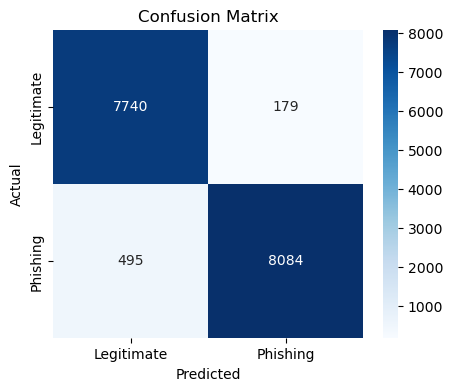

In [40]:
#evaluating the model 
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [42]:
#predicting on new email
def predict_email(text):
    cleaned = clean_text(text)
    vect = vectorizer.transform([cleaned])
    pred = model.predict(vect)[0]
    return "Phishing" if pred == 1 else "Legitimate"

In [43]:
# Example:
print(predict_email("Your account has been suspended. Click here to verify your details."))

Phishing


Model Analysis:

Accuracy: 95.91%
This model correctly classifies about 96 out of every 100 emails.

Precision (Phishing): 0.98
Of all emails predicted as phishing, 98% were actually phishing.

Recall (Phishing): 0.94
Of all actual phishing emails, 94% were correctly identified.

F1-Score: 0.96
This balances precision and recall. This model has a high value.

True Positives (TP): 8,084 (Phishing correctly identified)
True Negatives (TN): 7,740 (Legitimate correctly identified)
False Positives (FP): 179 (Legitimate misclassified as phishing)
False Negatives (FN): 495 (Phishing misclassified as legitimate)

Only a small fraction of phishing emails are missed (FN), and few legitimate emails are flagged as phishing (FP).



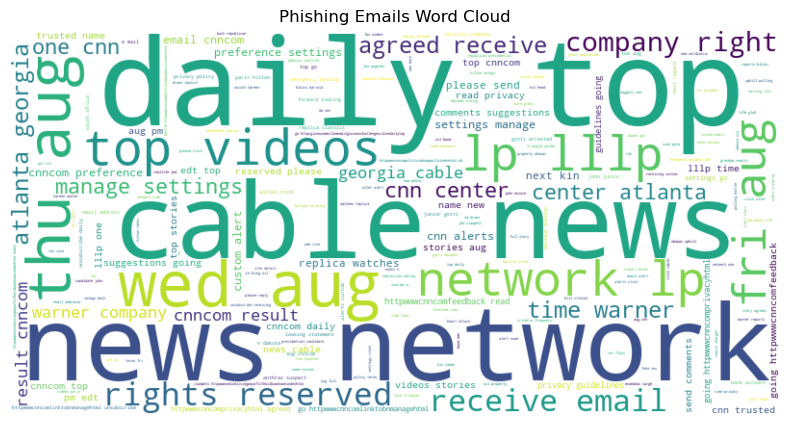

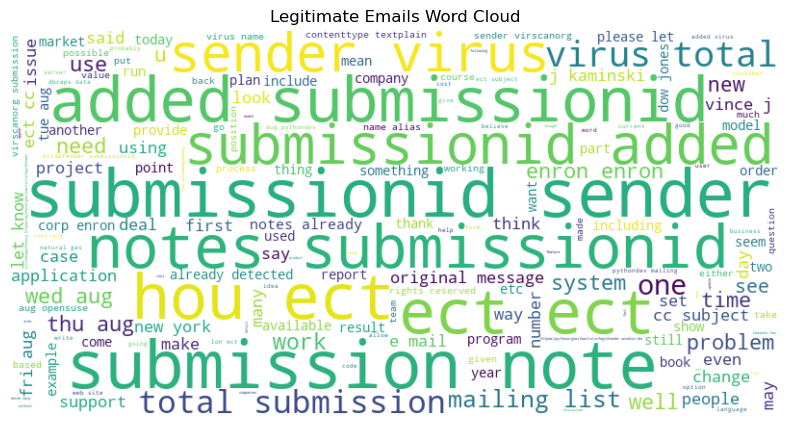

In [46]:
#wordcloud for phishing emails 
phishing_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(phishing_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Phishing Emails Word Cloud')
plt.show()

#wordcloud for legitimate emails
legit_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(legit_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Legitimate Emails Word Cloud')
plt.show()